In [ ]:
# Repository setup and reproducibility
from pathlib import Path
import sys

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
print("Backend:", backend_info())
ensure_seed(42)

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

# Project 3: Multiclass Classification — from scratch

## Goal
Generalize binary classification to K classes using softmax activation and categorical cross-entropy.

## Learning Objectives
- Derive softmax function and categorical cross-entropy loss
- Understand one-hot encoding and output layer design
- Implement multiclass logistic regression (softmax regression)
- Visualize decision boundaries in 3-class toy datasets
- Compare softmax to repeated one-vs-rest binary classification

## Prerequisites
- Projects 1–2: comfortable with gradient descent and cross-entropy

## What You'll Build
- NumPy-only softmax regression; confusion matrices; decision boundary plots

## Estimated Time
- 3–5 hours

---

# Project 3: Multi-class Classification with Softmax

## Goal
Generalize binary classification to multiple classes using softmax.

## Learning Objectives
- How does softmax generalize sigmoid?
- Why one-hot encode labels?
- Multi-class cross-entropy
- Understanding probability distributions

## Theoretical Foundation

### Softmax Function
$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

### Multi-class Cross-Entropy
$$L = -\frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K}y_{ik}\log(\hat{y}_{ik})$$

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/mark/git/learning-ml-to-llm')

from utils.data_generators import generate_multiclass_data
from sklearn.datasets import load_iris

print("Ready for multi-class classification!")

Ready for multi-class classification!


## Step 1: Generate Multi-class Data

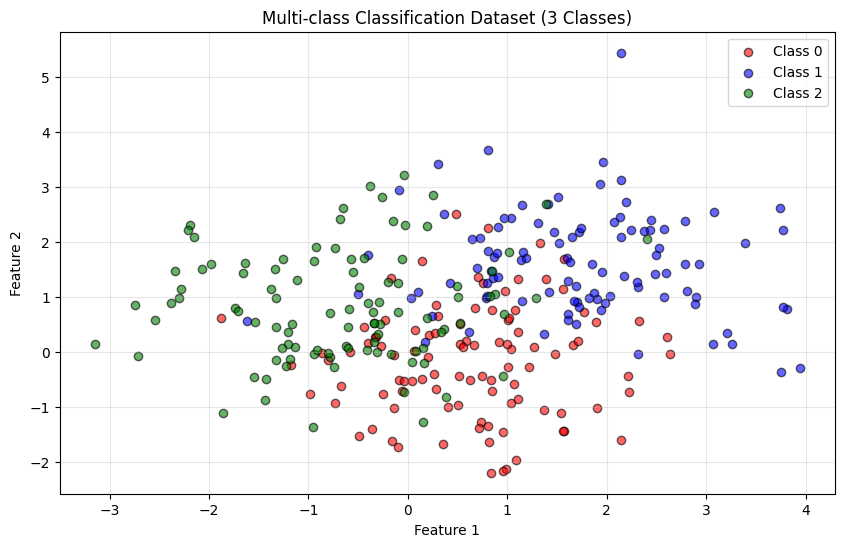

Dataset shape: (300, 2)
Number of classes: 3
Class 0 samples: 100
Class 1 samples: 100
Class 2 samples: 100


In [2]:
# Generate synthetic multi-class data
X, y = generate_multiclass_data(n_samples=300, n_classes=3, n_features=2, random_state=42)

# Visualize the data
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']
for class_idx in range(3):
    mask = y == class_idx
    plt.scatter(X[mask, 0], X[mask, 1], c=colors[class_idx], 
                label=f'Class {class_idx}', alpha=0.6, edgecolors='k')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Multi-class Classification Dataset (3 Classes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
for class_idx in range(3):
    print(f"Class {class_idx} samples: {np.sum(y == class_idx)}")

## Step 2: Implement Softmax Function

Input logits:
[[2.  1.  0.1]
 [1.  3.  0.2]
 [0.5 0.5 2.5]]

Softmax probabilities:
[[0.65900114 0.24243297 0.09856589]
 [0.11314284 0.8360188  0.05083836]
 [0.10650698 0.10650698 0.78698604]]

Sum of probabilities per sample (should be 1.0):
[1. 1. 1.]


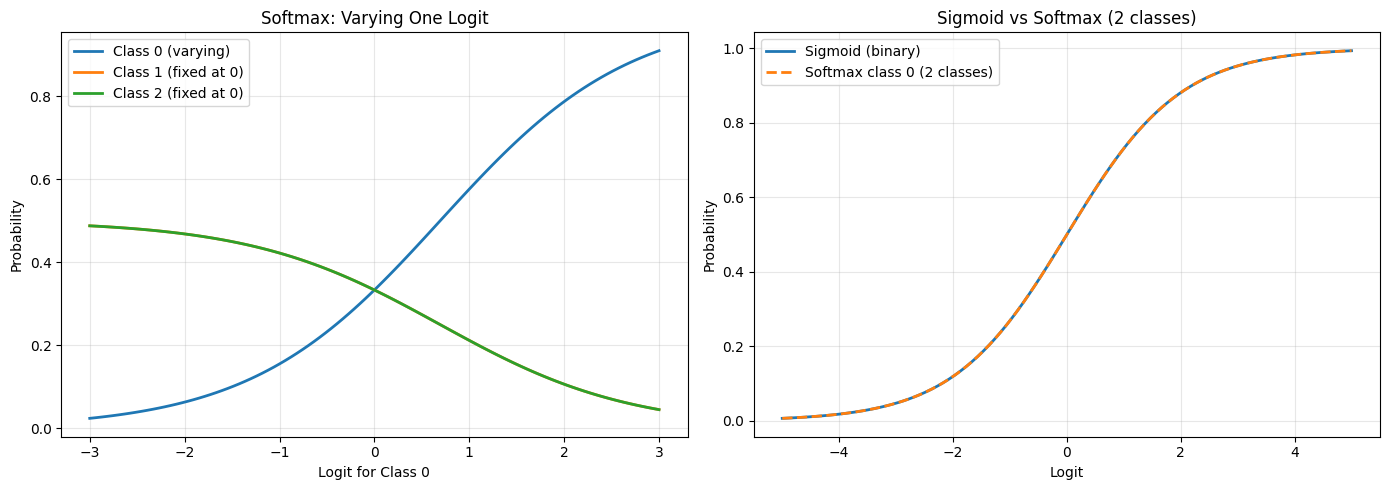


Softmax function implemented and visualized!


In [3]:
def softmax(z):
    """
    Compute the softmax function for multi-class classification.
    
    Parameters:
    -----------
    z : numpy array of shape (n_samples, n_classes)
        Raw logits
        
    Returns:
    --------
    numpy array of shape (n_samples, n_classes)
        Probability distribution over classes
    """
    # Subtract max for numerical stability
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Test softmax with a simple example
z_test = np.array([[2.0, 1.0, 0.1],
                   [1.0, 3.0, 0.2],
                   [0.5, 0.5, 2.5]])

probs = softmax(z_test)

print("Input logits:")
print(z_test)
print("\nSoftmax probabilities:")
print(probs)
print("\nSum of probabilities per sample (should be 1.0):")
print(np.sum(probs, axis=1))

# Visualize softmax behavior
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: softmax for varying first logit
z_range = np.linspace(-3, 3, 100)
z_array = np.column_stack([z_range, np.zeros(100), np.zeros(100)])
softmax_output = softmax(z_array)

axes[0].plot(z_range, softmax_output[:, 0], label='Class 0 (varying)', linewidth=2)
axes[0].plot(z_range, softmax_output[:, 1], label='Class 1 (fixed at 0)', linewidth=2)
axes[0].plot(z_range, softmax_output[:, 2], label='Class 2 (fixed at 0)', linewidth=2)
axes[0].set_xlabel('Logit for Class 0')
axes[0].set_ylabel('Probability')
axes[0].set_title('Softmax: Varying One Logit')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: compare sigmoid vs softmax for 2 classes
# Define sigmoid for comparison
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z_2class = np.linspace(-5, 5, 100)
sigmoid_output = sigmoid(z_2class)
softmax_2class = softmax(np.column_stack([z_2class, np.zeros(100)]))[:, 0]

axes[1].plot(z_2class, sigmoid_output, label='Sigmoid (binary)', linewidth=2)
axes[1].plot(z_2class, softmax_2class, label='Softmax class 0 (2 classes)', 
             linewidth=2, linestyle='--')
axes[1].set_xlabel('Logit')
axes[1].set_ylabel('Probability')
axes[1].set_title('Sigmoid vs Softmax (2 classes)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSoftmax function implemented and visualized!")

## Step 3: One-Hot Encoding

In [4]:
def one_hot_encode(y, n_classes):
    """
    Convert integer labels to one-hot encoded format.
    
    Parameters:
    -----------
    y : numpy array of shape (n_samples,)
        Integer class labels
    n_classes : int
        Number of classes
        
    Returns:
    --------
    numpy array of shape (n_samples, n_classes)
        One-hot encoded labels
    """
    n_samples = len(y)
    one_hot = np.zeros((n_samples, n_classes))
    one_hot[np.arange(n_samples), y] = 1
    return one_hot

# Test one-hot encoding
y_sample = np.array([0, 1, 2, 1, 0, 2])
y_one_hot = one_hot_encode(y_sample, n_classes=3)

print("Original labels:")
print(y_sample)
print("\nOne-hot encoded:")
print(y_one_hot)

# One-hot encode our dataset
n_classes = len(np.unique(y))
y_one_hot = one_hot_encode(y, n_classes)

print(f"\nDataset labels shape: {y.shape}")
print(f"One-hot encoded shape: {y_one_hot.shape}")
print(f"\nFirst 5 samples:")
print(f"Original: {y[:5]}")
print(f"One-hot:\n{y_one_hot[:5]}")

Original labels:
[0 1 2 1 0 2]

One-hot encoded:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

Dataset labels shape: (300,)
One-hot encoded shape: (300, 3)

First 5 samples:
Original: [2 2 0 1 2]
One-hot:
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


## Step 4: Multi-class Cross-Entropy Loss

In [5]:
def categorical_cross_entropy(y_true, y_pred, epsilon=1e-15):
    """
    Compute categorical cross-entropy loss.
    
    Parameters:
    -----------
    y_true : numpy array of shape (n_samples, n_classes)
        One-hot encoded true labels
    y_pred : numpy array of shape (n_samples, n_classes)
        Predicted probabilities
    epsilon : float
        Small constant to avoid log(0)
        
    Returns:
    --------
    float
        Average cross-entropy loss
    """
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Compute cross-entropy
    loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    return loss

# Test the loss function
y_true_test = np.array([[1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 1]])

# Perfect predictions (low loss)
y_pred_perfect = np.array([[0.99, 0.005, 0.005],
                           [0.005, 0.99, 0.005],
                           [0.005, 0.005, 0.99]])

# Poor predictions (high loss)
y_pred_poor = np.array([[0.33, 0.33, 0.34],
                        [0.33, 0.33, 0.34],
                        [0.33, 0.33, 0.34]])

loss_perfect = categorical_cross_entropy(y_true_test, y_pred_perfect)
loss_poor = categorical_cross_entropy(y_true_test, y_pred_poor)

print(f"Perfect predictions loss: {loss_perfect:.4f}")
print(f"Poor predictions loss: {loss_poor:.4f}")
print(f"\nLower loss is better!")

Perfect predictions loss: 0.0101
Poor predictions loss: 1.0987

Lower loss is better!


## Step 5: Implement Multi-class Logistic Regression

In [6]:
class MultiClassLogisticRegression:
    """
    Multi-class Logistic Regression using softmax and gradient descent.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        """
        Initialize the multi-class logistic regression model.
        
        Parameters:
        -----------
        learning_rate : float
            Step size for gradient descent
        n_iterations : int
            Number of training iterations
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.losses = []
        self.n_classes = None
        
    def fit(self, X, y):
        """
        Train the multi-class logistic regression model.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Training data
        y : numpy array of shape (n_samples,)
            Integer class labels
        """
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))
        
        # Convert labels to one-hot encoding
        y_one_hot = one_hot_encode(y, self.n_classes)
        
        # Initialize weights and bias
        self.weights = np.random.randn(n_features, self.n_classes) * 0.01
        self.bias = np.zeros((1, self.n_classes))
        
        # Gradient descent
        for i in range(self.n_iterations):
            # Forward pass
            logits = np.dot(X, self.weights) + self.bias
            predictions = softmax(logits)
            
            # Compute loss
            loss = categorical_cross_entropy(y_one_hot, predictions)
            self.losses.append(loss)
            
            # Compute gradients
            dlogits = predictions - y_one_hot
            dw = (1 / n_samples) * np.dot(X.T, dlogits)
            db = (1 / n_samples) * np.sum(dlogits, axis=0, keepdims=True)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Print progress
            if (i + 1) % 100 == 0:
                print(f"Iteration {i + 1}/{self.n_iterations}, Loss: {loss:.4f}")
    
    def predict_proba(self, X):
        """
        Predict probability distributions.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Input data
            
        Returns:
        --------
        numpy array of shape (n_samples, n_classes)
            Predicted probability distributions
        """
        logits = np.dot(X, self.weights) + self.bias
        return softmax(logits)
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Input data
            
        Returns:
        --------
        numpy array of shape (n_samples,)
            Predicted class labels
        """
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

print("MultiClassLogisticRegression class implemented!")

MultiClassLogisticRegression class implemented!


## Step 6: Train and Visualize Results

Iteration 100/1000, Loss: 0.6042
Iteration 200/1000, Loss: 0.5790
Iteration 300/1000, Loss: 0.5713
Iteration 400/1000, Loss: 0.5680
Iteration 500/1000, Loss: 0.5662
Iteration 600/1000, Loss: 0.5653
Iteration 700/1000, Loss: 0.5647
Iteration 800/1000, Loss: 0.5644
Iteration 900/1000, Loss: 0.5642
Iteration 1000/1000, Loss: 0.5640

Training Accuracy: 0.7867
Iteration 500/1000, Loss: 0.5662
Iteration 600/1000, Loss: 0.5653
Iteration 700/1000, Loss: 0.5647
Iteration 800/1000, Loss: 0.5644
Iteration 900/1000, Loss: 0.5642
Iteration 1000/1000, Loss: 0.5640

Training Accuracy: 0.7867


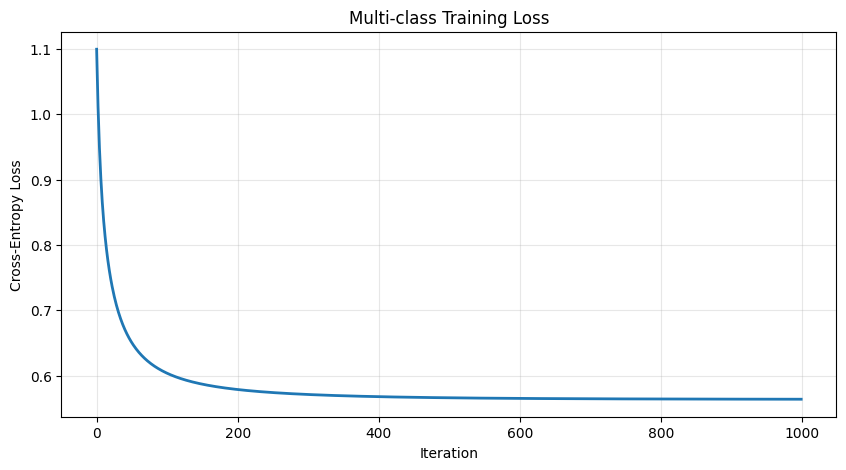

In [7]:
# Train the model
model = MultiClassLogisticRegression(learning_rate=0.1, n_iterations=1000)
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

# Calculate accuracy
accuracy = np.mean(y_pred == y)
print(f"\nTraining Accuracy: {accuracy:.4f}")

# Visualize loss curve
plt.figure(figsize=(10, 5))
plt.plot(model.losses, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.title('Multi-class Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## Step 7: Visualize Decision Boundaries

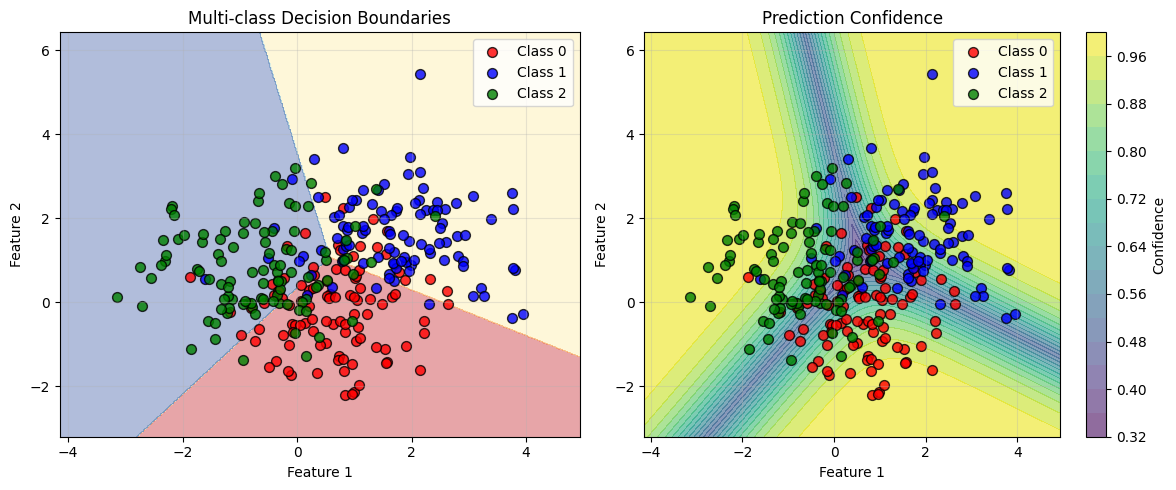

In [8]:
# Create a mesh to plot decision boundaries
h = 0.02  # Step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict on the mesh
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries
plt.figure(figsize=(12, 5))

# Left plot: Class predictions
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
colors = ['red', 'blue', 'green']
for class_idx in range(3):
    mask = y == class_idx
    plt.scatter(X[mask, 0], X[mask, 1], c=colors[class_idx], 
                label=f'Class {class_idx}', alpha=0.8, edgecolors='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Multi-class Decision Boundaries')
plt.legend()
plt.grid(True, alpha=0.3)

# Right plot: Confidence (max probability)
plt.subplot(1, 2, 2)
Z_proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_confidence = np.max(Z_proba, axis=1).reshape(xx.shape)
contour = plt.contourf(xx, yy, Z_confidence, alpha=0.6, cmap='viridis', levels=20)
plt.colorbar(contour, label='Confidence')
for class_idx in range(3):
    mask = y == class_idx
    plt.scatter(X[mask, 0], X[mask, 1], c=colors[class_idx], 
                label=f'Class {class_idx}', alpha=0.8, edgecolors='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Prediction Confidence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 8: Analyze Probability Distributions

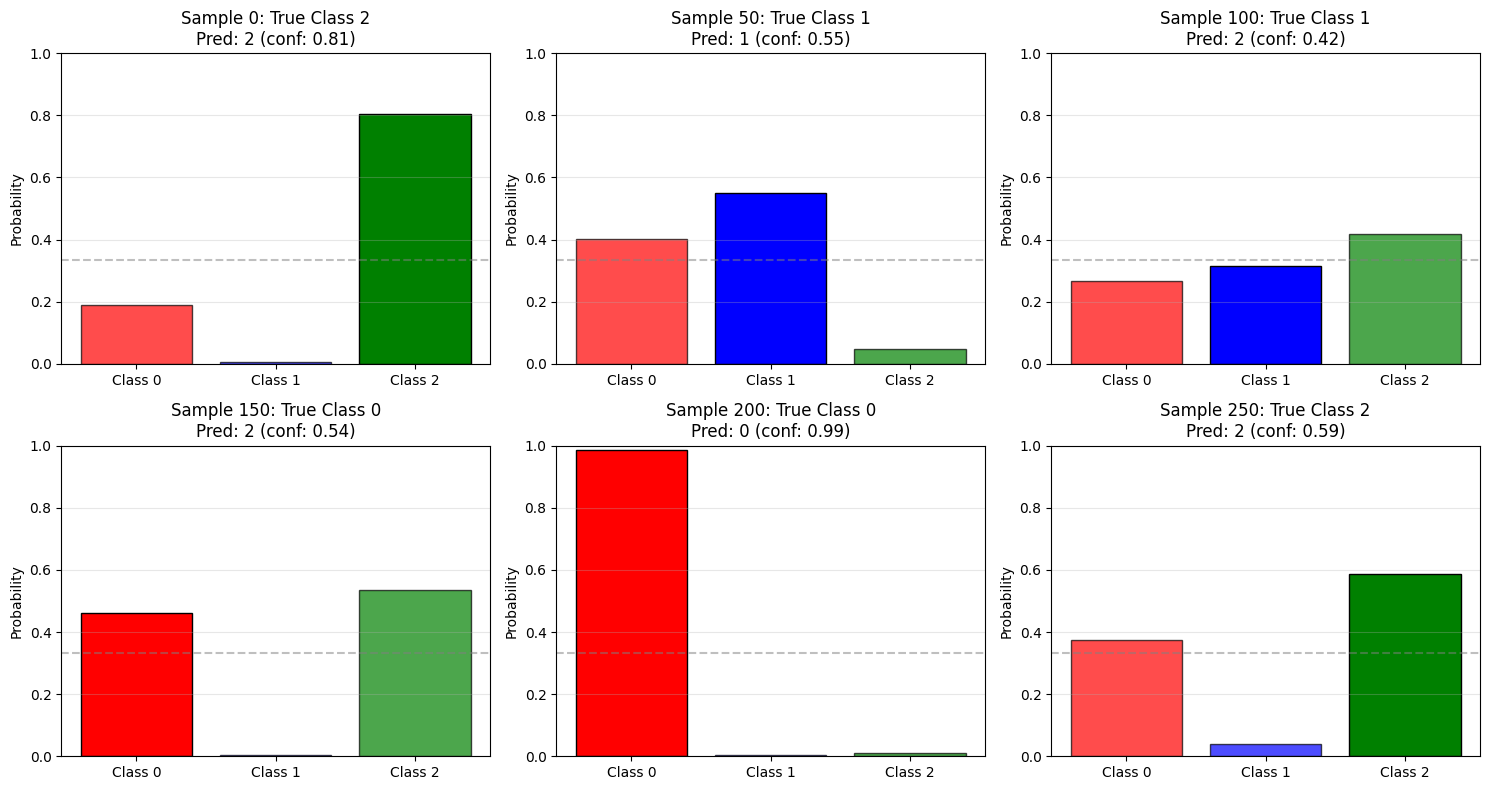


Detailed Probability Analysis:
Sample   True   Pred   Class 0    Class 1    Class 2   
0        2      2      0.1888     0.0057     0.8055    
50       1      1      0.4010     0.5506     0.0484    
100      1      2      0.2673     0.3161     0.4166    
150      0      2      0.4604     0.0034     0.5362    
200      0      0      0.9863     0.0039     0.0098    
250      2      2      0.3730     0.0404     0.5866    


In [9]:
# Select a few sample points to analyze
sample_indices = [0, 50, 100, 150, 200, 250]
sample_points = X[sample_indices]
sample_labels = y[sample_indices]
sample_probs = model.predict_proba(sample_points)

# Display probability distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, (i, point, true_label, probs) in enumerate(zip(sample_indices, sample_points, 
                                                         sample_labels, sample_probs)):
    ax = axes[idx]
    
    # Bar plot of probabilities
    bars = ax.bar(range(3), probs, color=['red', 'blue', 'green'], alpha=0.7, edgecolor='k')
    bars[true_label].set_alpha(1.0)  # Highlight true class
    
    ax.set_ylim(0, 1)
    ax.set_xticks(range(3))
    ax.set_xticklabels([f'Class {i}' for i in range(3)])
    ax.set_ylabel('Probability')
    ax.set_title(f'Sample {i}: True Class {true_label}\nPred: {np.argmax(probs)} (conf: {np.max(probs):.2f})')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=1/3, color='gray', linestyle='--', alpha=0.5, label='Random guess')

plt.tight_layout()
plt.show()

# Show detailed probability table
print("\nDetailed Probability Analysis:")
print("=" * 70)
print(f"{'Sample':<8} {'True':<6} {'Pred':<6} {'Class 0':<10} {'Class 1':<10} {'Class 2':<10}")
print("=" * 70)
for i, true_label, probs in zip(sample_indices, sample_labels, sample_probs):
    pred_label = np.argmax(probs)
    print(f"{i:<8} {true_label:<6} {pred_label:<6} {probs[0]:<10.4f} {probs[1]:<10.4f} {probs[2]:<10.4f}")
print("=" * 70)

## Step 9: Confusion Matrix

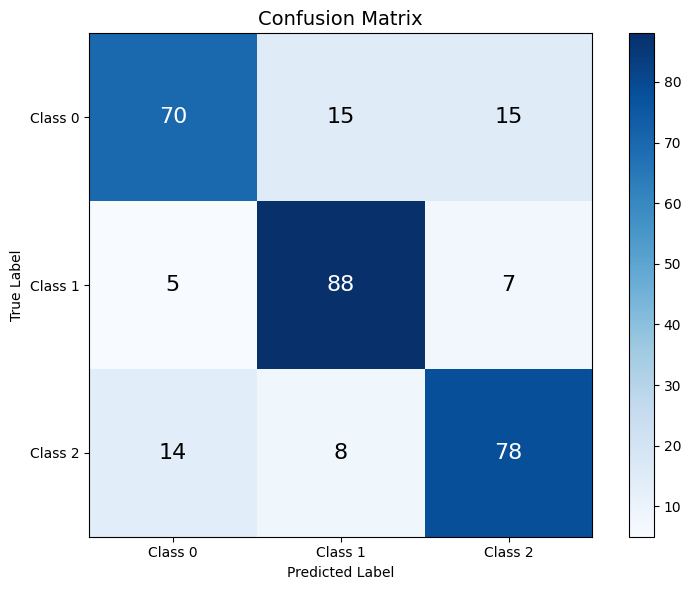


Per-class Metrics:
Class 0:
  Precision: 0.7865
  Recall: 0.7000
  F1-Score: 0.7407

Class 1:
  Precision: 0.7928
  Recall: 0.8800
  F1-Score: 0.8341

Class 2:
  Precision: 0.7800
  Recall: 0.7800
  F1-Score: 0.7800



In [10]:
# Compute confusion matrix
def compute_confusion_matrix(y_true, y_pred, n_classes):
    """
    Compute confusion matrix.
    
    Parameters:
    -----------
    y_true : numpy array
        True labels
    y_pred : numpy array
        Predicted labels
    n_classes : int
        Number of classes
        
    Returns:
    --------
    numpy array of shape (n_classes, n_classes)
        Confusion matrix
    """
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    return cm

# Compute confusion matrix
cm = compute_confusion_matrix(y, y_pred, n_classes=3)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix', fontsize=14)
plt.colorbar()

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=16)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(range(3), [f'Class {i}' for i in range(3)])
plt.yticks(range(3), [f'Class {i}' for i in range(3)])
plt.tight_layout()
plt.show()

# Calculate per-class metrics
print("\nPer-class Metrics:")
print("=" * 50)
for i in range(3):
    true_positives = cm[i, i]
    false_positives = cm[:, i].sum() - cm[i, i]
    false_negatives = cm[i, :].sum() - cm[i, i]
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Class {i}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print()

## Step 10: Test on Real Dataset (Iris)

In [11]:
# Load the Iris dataset
iris = load_iris()
X_iris = iris.data[:, :2]  # Use only first 2 features for visualization
y_iris = iris.target

print("Iris Dataset:")
print(f"Shape: {X_iris.shape}")
print(f"Classes: {iris.target_names}")
print(f"Features (first 2): {iris.feature_names[:2]}")

# Train model on Iris dataset
model_iris = MultiClassLogisticRegression(learning_rate=0.1, n_iterations=1000)
model_iris.fit(X_iris, y_iris)

# Make predictions
y_pred_iris = model_iris.predict(X_iris)
accuracy_iris = np.mean(y_pred_iris == y_iris)

print(f"\nIris Dataset Accuracy: {accuracy_iris:.4f}")

Iris Dataset:
Shape: (150, 2)
Classes: ['setosa' 'versicolor' 'virginica']
Features (first 2): ['sepal length (cm)', 'sepal width (cm)']
Iteration 100/1000, Loss: 0.7162
Iteration 200/1000, Loss: 0.6233
Iteration 300/1000, Loss: 0.5809
Iteration 400/1000, Loss: 0.5555
Iteration 500/1000, Loss: 0.5380
Iteration 600/1000, Loss: 0.5249
Iteration 700/1000, Loss: 0.5145
Iteration 800/1000, Loss: 0.5059
Iteration 900/1000, Loss: 0.4987
Iteration 1000/1000, Loss: 0.4924

Iris Dataset Accuracy: 0.7800


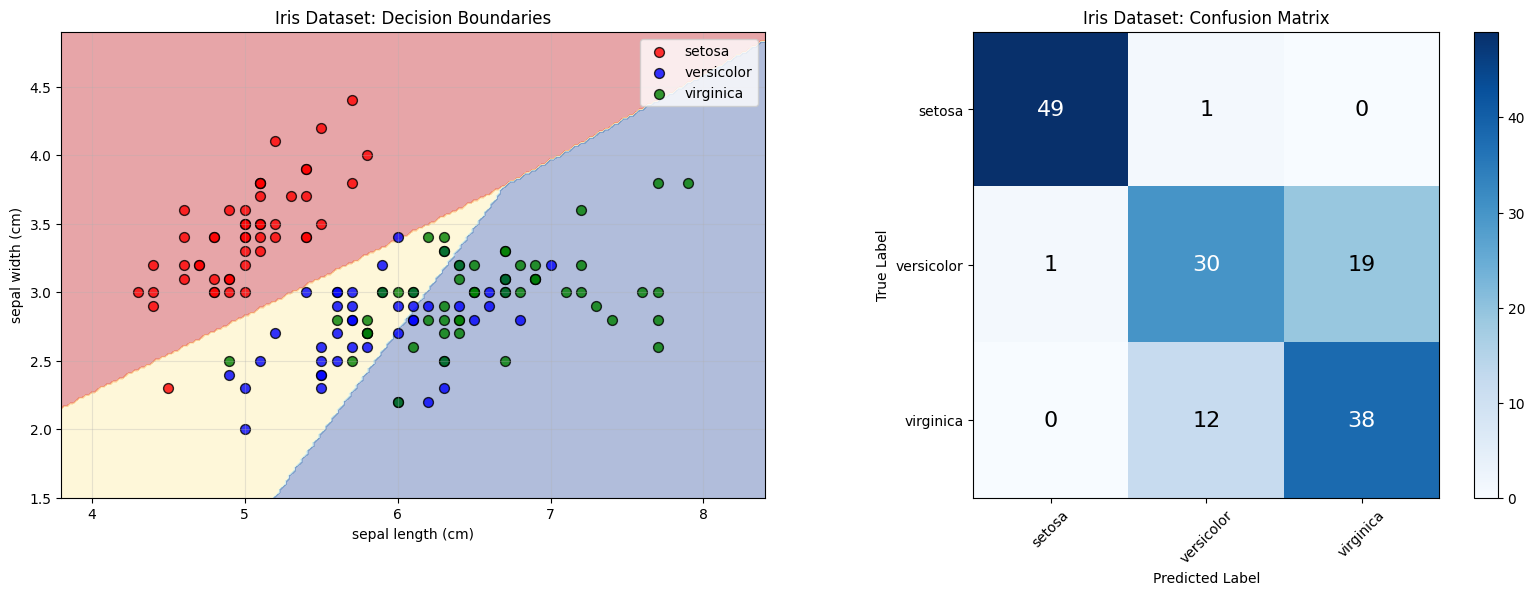

In [12]:
# Visualize Iris results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Decision boundaries
ax = axes[0]
h = 0.02
x_min, x_max = X_iris[:, 0].min() - 0.5, X_iris[:, 0].max() + 0.5
y_min, y_max = X_iris[:, 1].min() - 0.5, X_iris[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model_iris.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
colors_iris = ['red', 'blue', 'green']
for class_idx in range(3):
    mask = y_iris == class_idx
    ax.scatter(X_iris[mask, 0], X_iris[mask, 1], c=colors_iris[class_idx], 
               label=iris.target_names[class_idx], alpha=0.8, edgecolors='k', s=50)
ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.set_title('Iris Dataset: Decision Boundaries')
ax.legend()
ax.grid(True, alpha=0.3)

# Right plot: Confusion matrix
ax = axes[1]
cm_iris = compute_confusion_matrix(y_iris, y_pred_iris, n_classes=3)
im = ax.imshow(cm_iris, interpolation='nearest', cmap='Blues')
ax.set_title('Iris Dataset: Confusion Matrix')
plt.colorbar(im, ax=ax)

thresh = cm_iris.max() / 2.
for i in range(cm_iris.shape[0]):
    for j in range(cm_iris.shape[1]):
        ax.text(j, i, format(cm_iris[i, j], 'd'),
               ha="center", va="center",
               color="white" if cm_iris[i, j] > thresh else "black",
               fontsize=16)

ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_xticks(range(3))
ax.set_xticklabels(iris.target_names, rotation=45)
ax.set_yticks(range(3))
ax.set_yticklabels(iris.target_names)

plt.tight_layout()
plt.show()

## Exercises & Extensions

**Warm-up**:
1. Compute softmax by hand for a vector [1, 2, 3]. Verify it sums to 1.
2. One-hot encode 5 samples from iris dataset.
3. Compare softmax to sigmoid applied K times (one-vs-rest). When are they equivalent?

**Intermediate**:
4. Add L2 regularization. How does it smooth decision boundaries?
5. Implement confusion matrix. Which classes are confused most?
6. Plot per-class precision/recall. Are some classes harder to learn?

**Advanced**:
7. Implement mini-batch softmax regression (batch size = 16).
8. Use cross-validation to select regularization strength.
9. Compare to scikit-learn's LogisticRegression (multi_class='multinomial'). Are weights similar?

---

## Summary & Bridge Forward

**What you learned**:
- Softmax generalizes sigmoid to K classes.
- Categorical cross-entropy is the multiclass loss.
- One-hot encoding maps class labels to probability targets.
- Gradient descent still works: just a different loss.
- Decision boundaries are now K-1 dimensional hyperplanes.

**Why this matters**:
- Softmax is the output layer of most classifiers (including neural networks, transformers).
- Cross-entropy loss dominates deep learning.
- Understanding multiclass prepares you for hierarchical/structured prediction.

**Next project** (Regularization):
- Add L1/L2 penalties to prevent overfitting.
- Use same softmax regression; just modified loss.

**Your takeaway**: K-class classification is K-dimensional output + softmax + categorical cross-entropy. Gradient descent remains universal.

## Key Insights and Learning Summary

### How does softmax generalize sigmoid?
- **Sigmoid**: For binary classification (2 classes), outputs probability of one class
- **Softmax**: For multi-class (K classes), outputs probability distribution over all classes
- When K=2, softmax reduces to sigmoid behavior
- Both ensure outputs sum to 1 (probability distribution)

### Why one-hot encode labels?
- One-hot encoding creates a target probability distribution
- Matches the softmax output format (probability per class)
- Enables element-wise comparison in cross-entropy loss
- Example: Label 2 → [0, 0, 1] for 3 classes

### Multi-class cross-entropy
- Measures how well predicted probabilities match true distribution
- Penalizes confident wrong predictions more heavily
- Sum over all classes, not just the true class
- Lower loss = better probability estimates

### Understanding probability distributions
- Softmax ensures all probabilities are positive and sum to 1
- High confidence = one probability close to 1, others near 0
- Low confidence = probabilities spread more evenly
- Decision boundary = where max probability switches between classes